In [1]:
audio = "Audio/audio_features.csv" # video id
text = "Linguistic/processed_text_features.csv" # video_id
meta = "Metadata/video_metadata.csv" # video_id
visual = "Visual/combined_visual_features.csv" # video_id
motion = "Motion/motion_data.csv" # video_id

In [2]:
import pandas as pd
import os

In [3]:
audio_df = pd.read_csv(audio); audio_df.rename(columns={"video id": "video_id"}, inplace=True) # make "video id" match the others
text_df = pd.read_csv(text); text_df.rename(columns={"language": "detected_language"}, inplace=True)
meta_df = pd.read_csv(meta); meta_df.rename(columns={"language": "reported_language"}, inplace=True)
visual_df = pd.read_csv(visual)
motion_df = pd.read_csv(motion); motion_df = motion_df.drop(['file_name'], axis=1) # same as video_id

dataframes = [audio_df, text_df, meta_df, visual_df, motion_df]

In [4]:
video_folder = '../YouTube_Downloader/Complete_Downloads'

files = os.listdir(video_folder)
mp4_files = [file for file in files if file.endswith('.mp4')]
video_id = [os.path.splitext(filename)[0] for filename in mp4_files]
len(video_id) # need 20180

20180

In [5]:
def check_ids(data):
    ids = set(data['video_id'].unique())
    missing = set(video_id) - ids
    non_valid = ids - set(video_id)
    out = {
        "missing": missing,
        "non_valid": non_valid,
        "n_miss": len(missing),
        "n_bad": len(non_valid)
    }
    return out

In [73]:
for data in dataframes:
    result = check_ids(data)
    print(f"missing ids = {result["n_miss"]} \t Non-valid ids = {result["n_bad"]}")

missing ids = 0 	 Non-valid ids = 0
missing ids = 9224 	 Non-valid ids = 0
missing ids = 2 	 Non-valid ids = 2
missing ids = 0 	 Non-valid ids = 0
missing ids = 28 	 Non-valid ids = 0


In [76]:
check_ids(meta_df) # these are two movies and their trailer (from the .json file) 

{'missing': {'TFHjveEp9qI', 'eMIXCCpDykI'},
 'non_valid': {'iFwONUmec-o', 'qJfCi1UT4n4'},
 'n_miss': 2,
 'n_bad': 2}

In [78]:
# Mapping of old video_ids to "correct" ones
video_id_map = {
    'iFwONUmec-o': 'TFHjveEp9qI',
    'qJfCi1UT4n4': 'eMIXCCpDykI'
}

# Update the 'video_id' column using the mapping
meta_df['video_id'] = meta_df['video_id'].replace(video_id_map)
check_ids(meta_df)

{'missing': set(), 'non_valid': set(), 'n_miss': 0, 'n_bad': 0}

In [6]:
for data in dataframes:
    result = check_ids(data)
    print(f"missing ids = {result["n_miss"]} \t Non-valid ids = {result["n_bad"]}")

missing ids = 0 	 Non-valid ids = 0
missing ids = 9224 	 Non-valid ids = 0
missing ids = 0 	 Non-valid ids = 0
missing ids = 0 	 Non-valid ids = 0
missing ids = 0 	 Non-valid ids = 0


# Join dataframes

In [7]:
nb_columns = -4 # for the ids
columns = set()
for dat in dataframes:
    nb_columns += len(dat.columns)
    columns.update(dat.columns.to_list())
nb_columns, len(columns)

(353, 353)

In [8]:
# Merge all dataframes using outer join
df = (audio_df
      .merge(text_df, on="video_id", how="outer")
      .merge(meta_df, on="video_id", how="outer")
      .merge(visual_df, on="video_id", how="outer")
      .merge(motion_df, on="video_id", how="outer"))

In [9]:
len(df['video_id'].unique())

20180

In [10]:
len(df.columns.to_list())

353

In [11]:
df.columns.to_list()

['video_id',
 'mean_mfccs_1',
 'mean_mfccs_2',
 'mean_mfccs_3',
 'mean_mfccs_4',
 'mean_mfccs_5',
 'mean_mfccs_6',
 'mean_mfccs_7',
 'mean_mfccs_8',
 'mean_mfccs_9',
 'mean_mfccs_10',
 'mean_mfccs_11',
 'mean_mfccs_12',
 'mean_mfccs_13',
 'std_mfccs_1',
 'std_mfccs_2',
 'std_mfccs_3',
 'std_mfccs_4',
 'std_mfccs_5',
 'std_mfccs_6',
 'std_mfccs_7',
 'std_mfccs_8',
 'std_mfccs_9',
 'std_mfccs_10',
 'std_mfccs_11',
 'std_mfccs_12',
 'std_mfccs_13',
 'volatility_mfccs_1',
 'volatility_mfccs_2',
 'volatility_mfccs_3',
 'volatility_mfccs_4',
 'volatility_mfccs_5',
 'volatility_mfccs_6',
 'volatility_mfccs_7',
 'volatility_mfccs_8',
 'volatility_mfccs_9',
 'volatility_mfccs_10',
 'volatility_mfccs_11',
 'volatility_mfccs_12',
 'volatility_mfccs_13',
 'mean_vol_contour_4hz',
 'std_vol_contour_4hz',
 'volatility_vol_contour_4hz',
 'mean_freq_centroid',
 'std_freq_centroid',
 'volatility_freq_centroid',
 'mean_freq_bandwidth',
 'std_freq_bandwidth',
 'volatility_freq_bandwidth',
 'mean_energy_ra

In [76]:
df.to_csv("all_features.csv", index=False)

# Exploration before clustering

In [61]:
transcribed = (audio_df
      .merge(meta_df, on="video_id", how="outer")
      .merge(visual_df, on="video_id", how="outer")
      .merge(motion_df, on="video_id", how="outer")
      .merge(text_df, on="video_id", how="inner"))


In [62]:
transcribed = transcribed.drop([col for col in meta_df.columns.to_list() if col not in ['video_id', 'duration_seconds']], axis=1)
transcribed = transcribed.select_dtypes(include=["float64", "int64"])
missing_values = transcribed.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

volatility_mfccs_1                     208
volatility_mfccs_2                     208
volatility_mfccs_3                     208
volatility_mfccs_4                     208
volatility_mfccs_5                     208
volatility_mfccs_6                     208
volatility_mfccs_7                     208
volatility_mfccs_8                     208
volatility_mfccs_9                     208
volatility_mfccs_10                    208
volatility_mfccs_11                    208
volatility_mfccs_12                    208
volatility_mfccs_13                    208
volatility_vol_contour_4hz             208
volatility_freq_centroid               208
volatility_freq_bandwidth              208
volatility_energy_ratio_0_630          208
volatility_energy_ratio_630_1720       208
volatility_energy_ratio_1720_4400      208
volatility_non_silence_ratio           208
volatility_volume_dynamic_range        208
volatility_mean_zero_crossing_rate     208
volatility_volume_std_dev              208
nb_faces_vo

In [51]:
df = df.drop([col for col in meta_df.columns.to_list() if col not in ['video_id', 'duration_seconds']], axis=1) # drop metadata, keep duration and id


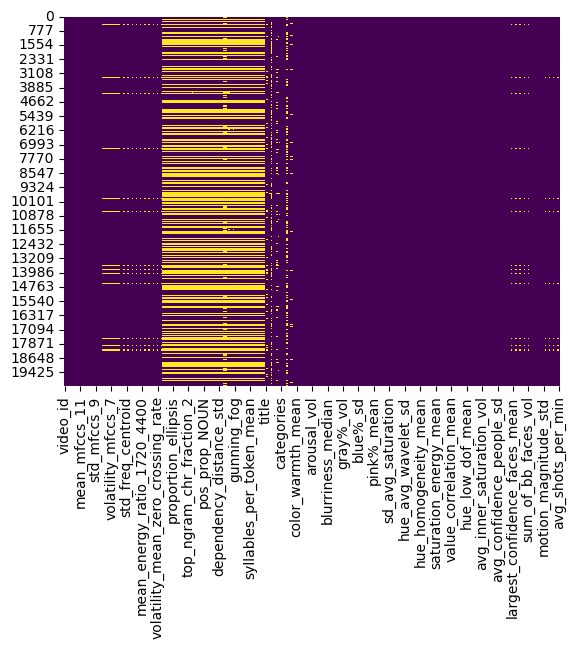

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isna(), cmap="viridis", cbar=False)
plt.show()